In [1]:
#IMPORT LIBRARIES
from src.read_data import read_datasets, merge_phylo_data, load_reference_data, load_reference_data2
from src.plot import plot_hiv_genome
from src.compute_MAF import compute_MAF
from src.preprocess import stratify5
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pyreadr
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


In [2]:
#READ DATA
data_frames = read_datasets()
agg_data_df, phylo_features_df, maf_data_df, rakai_maf_data_df, rakai_phylo_data_df = data_frames.values()
botswana = pyreadr.read_r('./data/raw/BW_tshedimoso_TSI_inclpangeaID.RDS')[None]

In [3]:
#MERGE PHYLOGENETIC DATA
botswana_unique = botswana.drop_duplicates(subset=['pt_letter', 'TSI_days'])
phylo_features_df = phylo_features_df.merge(botswana_unique[['pt_letter', 'TSI_days', 'RENAME_ID']], on=['pt_letter', 'TSI_days'], how='inner')
phylo = merge_phylo_data(phylo_features_df, rakai_phylo_data_df)

/Users/andreawickman/saving_lives/src/read_data.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rakai_data['xcoord'] = np.ceil(rakai_data['xcoord'])


# 1 - BOTSWANA VALUES

In [13]:
agg_data_df = stratify5(agg_data_df)

In [31]:
def run_forest_class(X_train, y_train, X_test, y_test, predictors, n_estimators=100, random_state=42):
    # Select the predictor columns
    X_train_subset = X_train[predictors]
    X_test_subset = X_test[predictors]
    # Fill missing values with zeroes
    X_train_subset = X_train_subset.fillna(0)
    X_test_subset = X_test_subset.fillna(0)

    #DEFINE RANDOM FOREST CLASSIFIER INSTANCE   
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
    #FIT RANDOM FOREST CLASSIFIER ON TRAINING DATA 
    rf.fit(X_train_subset, y_train)
    #MAKE PREDICTIONS ON TEST DATA
    y_pred = rf.predict(X_test_subset)

    #COMPUTE CLASSIFICATION ACCURACY 
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

test_split = 0.25

In [15]:
# SET Y
target_column = 'TSI_category'

predictor_sets = {
    'Alex (Botswana)': ["gag_lrtt", "gag_tips", "gag_maf3c", "pol_lrtt", "gp120_lrtt", "gp120_tips", "gp41_tips","gp41_maf12c","gp41_maf3c"],
    'Full Genome (Botswana)': ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_tips', 'genome_dual'],
    #'LRTT (Botswana)': ['genome_lrtt', 'gag_lrtt', 'pol_lrtt', 'gp120_lrtt', 'gp41_lrtt'],
    'ENV (Botswana)': ['gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips'],
    'GAG_ENV (Botswana)': ['gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips', 'gag_dual'],
    'All (Botswana)': ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_tips', 'gag_lrtt', 'gag_tips', 'gag_maf12c', 'gag_maf3c', 'pol_lrtt', 'pol_tips',
            'pol_maf12c', 'pol_maf3c', 'gp120_lrtt', 'gp120_tips', 'gp120_maf12c', 'gp120_maf3c', 'gp41_lrtt', 'gp41_tips','gp41_maf12c', 'gp41_maf3c'],
    'Genome_ENV_GAG (Botswana)': ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_tips', 'genome_dual', 'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gag_lrtt', 'gag_maf12c', 'gag_maf3c'],
    
}
#PREDICTOR AND TARGET SET
X = agg_data_df.drop(columns=[target_column])
y = agg_data_df[target_column]
#TRAIN AND TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_split, random_state=42)

In [16]:
results = []

for set_name, predictors in predictor_sets.items():
    accuracy = run_forest_class(X_train, y_train, X_test, y_test, predictors)
    results.append({'Predictor Set': set_name, 'Accuracy': accuracy})

results_botswana = pd.DataFrame(results)
results_botswana.sort_values(by = 'Accuracy', ascending=False)

     gag_lrtt   gag_tips  gag_maf3c  pol_lrtt  gp120_lrtt  gp120_tips  \
263  0.001440  31.666667   0.013823  0.001957    0.004322   35.475410   
67   0.000312  17.216667   0.002421  0.000000    0.000224   11.467742   
75   0.000373  22.066667   0.005545  0.000520    0.000308   17.516129   
109  0.001061  36.875000   0.004553  0.000198    0.001007   32.065574   
97   0.000263  14.355556   0.001550  0.000012    0.000107   10.396226   
..        ...        ...        ...       ...         ...         ...   
188  0.001126  21.000000   0.009871  0.000590    0.001021   12.934426   
71   0.000554  17.483333   0.001631  0.000078    0.000194   11.806452   
106  0.000805  31.625000   0.003068  0.000181    0.000658   18.426230   
270  0.001832  28.702703   0.010832  0.000409    0.000535   16.209677   
102  0.000525  29.044444   0.002330  0.000057    0.000185   17.622642   

     gp41_tips  gp41_maf12c  gp41_maf3c  
263  30.951220     0.008623    0.016385  
67   11.756098     0.003325    0.002135

,Predictor Set,Accuracy
0,Alex (Botswana),0.619718
4,All (Botswana),0.605634
1,Full Genome (Botswana),0.591549
3,GAG_ENV (Botswana),0.591549
5,Genome_ENV_GAG (Botswana),0.591549
2,ENV (Botswana),0.521127


# 2- BOTSWANA + RAKAI

In [4]:
phylo = pd.read_csv('./data/derived/imputed_phylo_data.csv')
maf = pd.read_csv('./data/derived/window_MAF.csv')

/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_79711/2588309072.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  phylo = pd.read_csv('./data/derived/imputed_phylo_data.csv')


In [5]:
def generate_lrtt_features(df, gag, pol, gp120, gp41, feature = 'normalised.largest.rtt'):
    ''' Generate aggregated LRTT predictors. '''
    results = []
    
    # Group by RENAME_ID
    grouped = df.groupby('RENAME_ID')
    
    for name, group in grouped:
        # Convert xcoord to integer for matching
        group['xcoord'] = group['xcoord'].astype(int)
        # Genome-level average
        genome_lrtt = group['normalised.largest.rtt'].mean()
        genome_tips = group['tips'].mean()
        
        # Gene-level averages
        gag_lrtt = group[group['xcoord'].isin(gag)][feature].mean()
        pol_lrtt = group[group['xcoord'].isin(pol)][feature].mean()
        gp120_lrtt = group[group['xcoord'].isin(gp120)][feature].mean()
        gp41_lrtt = group[group['xcoord'].isin(gp41)][feature].mean()
        
        gag_tips = group[group['xcoord'].isin(gag)]['tips'].mean()
        pol_tips = group[group['xcoord'].isin(gag)]['tips'].mean()
        gp120_tips = group[group['xcoord'].isin(gag)]['tips'].mean()
        gp41_tips = group[group['xcoord'].isin(gag)]['tips'].mean()

        #save tsi
        tsi_days = group['TSI_days'].iloc[0]

        results.append({
            'RENAME_ID': name,
            'TSI_days': tsi_days,
            'genome_lrtt': genome_lrtt,
            'genome_tips': genome_tips,
            'gag_lrtt': gag_lrtt,
            'gag_tips': gag_tips,
            'pol_lrtt': pol_lrtt,
            'pol_tips': pol_tips,
            'gp120_lrtt': gp120_lrtt,
            'gp120_tips': gp120_tips,
            'gp41_lrtt': gp41_lrtt,
            'gp41_tips': gp41_tips
        })
    
    return pd.DataFrame(results)

def generate_maf_features(df, gag, pol, gp120, gp41):
    ''' Generate aggregated LRTT predictors. '''
    results = []
    
    # Group by RENAME_ID
    grouped = df.groupby('RENAME_ID')
    
    
    for name, group in grouped:
        
        # Convert xcoord to integer for matching
        group['Window_Centre'] = group['Window_Centre'].astype(int)
        group['Window_Centre'] = group['Window_Centre'].astype(int)
        # Genome-level average
        genome_maf12c = group['MAF12c_Mean'].mean()
        genome_maf3c = group['MAF3c_Mean'].mean()
        
        # Gene-level averages
        gag_maf12c = group[group['Window_Centre'].isin(gag)]['MAF12c_Mean'].mean()
        pol_maf12c = group[group['Window_Centre'].isin(pol)]['MAF12c_Mean'].mean()
        gp120_maf12c = group[group['Window_Centre'].isin(gp120)]['MAF12c_Mean'].mean()
        gp41_maf12c = group[group['Window_Centre'].isin(gp41)]['MAF12c_Mean'].mean()

        # Gene-level averages
        gag_maf3c = group[group['Window_Centre'].isin(gag)]['MAF3c_Mean'].mean()
        pol_maf3c = group[group['Window_Centre'].isin(pol)]['MAF3c_Mean'].mean()
        gp120_maf3c = group[group['Window_Centre'].isin(gp120)]['MAF3c_Mean'].mean()
        gp41_maf3c = group[group['Window_Centre'].isin(gp41)]['MAF3c_Mean'].mean()
        
        #save tsi
        tsi_days = group['TSI_days'].iloc[0]

        results.append({
            'RENAME_ID': name,
            'TSI_days': tsi_days,
            'genome_maf12c': genome_maf12c,
            'genome_maf3c': genome_maf3c,
            'gag_maf12c': gag_maf12c,
            'gag_maf3c': gag_maf3c,
            'pol_maf12c': pol_maf12c,
            'pol_maf3c': pol_maf3c,
            'gp120_maf12c': gp120_maf12c,
            'gp120_maf3c': gp120_maf3c,
            'gp41_maf12c': gp41_maf12c,
            'gp41_maf3c': gp41_maf3c,
        })
    
    return pd.DataFrame(results)

In [6]:
first_second_codon_pos, third_codon_pos, gag, pol, gp120, gp41 = load_reference_data2('./data/')

In [7]:
mean_lrtt_features = generate_lrtt_features(phylo, gag, pol, gp120, gp41)
mean_lrtt_features = stratify5(mean_lrtt_features)

In [8]:
mean_maf_features = generate_maf_features(maf, gag, pol, gp120, gp41)

In [9]:
#MERGE AGGREGATED FEATURES
mean_features = pd.merge(mean_lrtt_features, mean_maf_features, on=['RENAME_ID', 'TSI_days'], how = 'inner')
mean_features = stratify5(mean_features)

(array([144., 195.,  38.,  31.,  48.,  17.,  29.,  15.,  12.,  15.,   6.,
         10.,  15.,   7.,   6.,   6.,   9.,   6.,   2.,   4.,   2.,   3.,
          0.,   1.,   2.,   1.,   0.,   0.,   0.,   1.]),
 array([   0. ,  217.6,  435.2,  652.8,  870.4, 1088. , 1305.6, 1523.2,
        1740.8, 1958.4, 2176. , 2393.6, 2611.2, 2828.8, 3046.4, 3264. ,
        3481.6, 3699.2, 3916.8, 4134.4, 4352. , 4569.6, 4787.2, 5004.8,
        5222.4, 5440. , 5657.6, 5875.2, 6092.8, 6310.4, 6528. ]),
 <BarContainer object of 30 artists>)

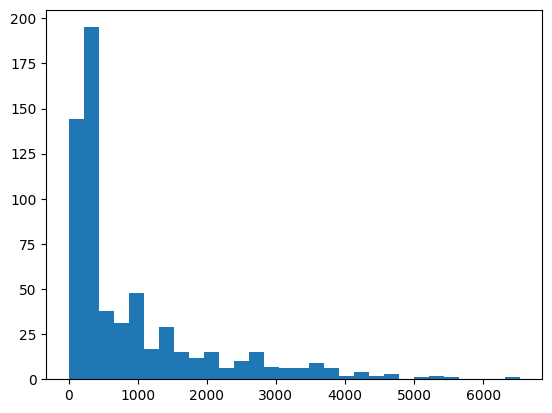

In [18]:
plt.hist(mean_features['TSI_days'], bins = 30)

In [57]:
# SET Y
target_column = 'TSI_category'

predictor_sets = {
    'Alex (B+U)': ["gag_lrtt", "gag_tips", "gag_maf3c", "pol_lrtt", "gp120_lrtt", "gp120_tips", "gp41_tips" ,"gp41_maf12c","gp41_maf3c"], #without tips 
    'Genome (B+U) ': ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_tips'],
    #'LRTT (B+U)': ['genome_lrtt', 'gag_lrtt', 'pol_lrtt', 'gp120_lrtt', 'gp41_lrtt'],
    'ENV (B+U)': ['gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c'],
    'GAG_ENV (B+U)': ['gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips', 'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips'],
    'All (B+U)': ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_tips', 'gag_lrtt', 'gag_tips', 'gag_maf12c', 'gag_maf3c', 'pol_lrtt', 'pol_tips',
            'pol_maf12c', 'pol_maf3c', 'gp120_lrtt', 'gp120_tips', 'gp120_maf12c', 'gp120_maf3c', 'gp41_lrtt', 'gp41_tips','gp41_maf12c', 'gp41_maf3c'],
    'Genome_ENV_GAG (B+U)': ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_tips' , 'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gag_lrtt', 'gag_maf12c', 'gag_maf3c'],  
}


#PREDICTOR AND TARGET SET
X = mean_features.drop(columns=[target_column])
y = mean_features[target_column]
#TRAIN AND TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [58]:
results = []

for set_name, predictors in predictor_sets.items():
    accuracy = run_forest_class(X_train, y_train, X_test, y_test, predictors)
    results.append({'Predictor Set': set_name, 'Accuracy': accuracy})

results_df = pd.DataFrame(results)
results_df.sort_values(by = 'Accuracy', ascending=False)

,Predictor Set,Accuracy
5,Genome_ENV_GAG (B+U),0.573248
3,GAG_ENV (B+U),0.566879
4,All (B+U),0.560510
0,Alex (B+U),0.522293
1,Genome (B+U),0.509554
2,ENV (B+U),0.433121


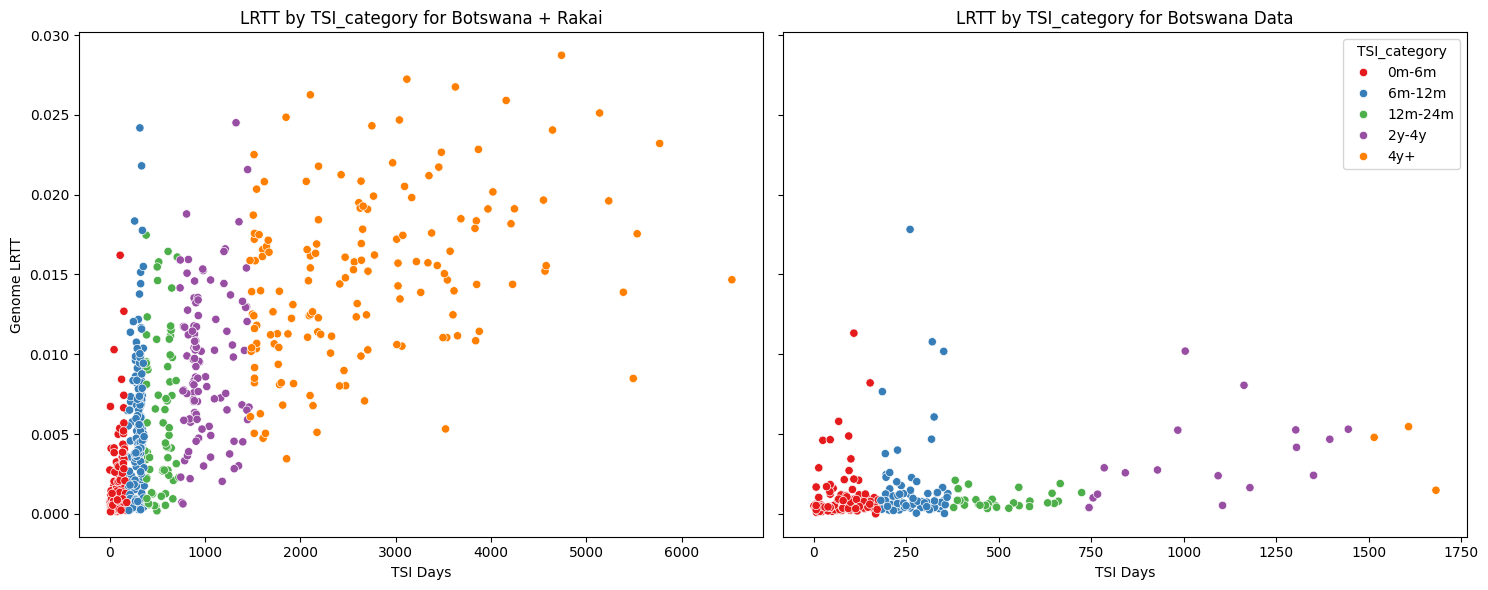

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Plot 1: mean_lrtt_features
sns.scatterplot(ax=axes[0], data=mean_lrtt_features, x='TSI_days', y='genome_lrtt', hue='TSI_category', palette='Set1', legend = False)
axes[0].set_title('LRTT by TSI_category for Botswana + Rakai')
axes[0].set_xlabel('TSI Days')
axes[0].set_ylabel('Genome LRTT')

# Plot 2: agg_data_df
sns.scatterplot(ax=axes[1], data=agg_data_df, x='TSI_days', y='genome_lrtt', hue='TSI_category', palette='Set1')
axes[1].set_title('LRTT by TSI_category for Botswana Data')
axes[1].set_xlabel('TSI Days')
axes[1].set_ylabel('')


plt.tight_layout()
plt.show()

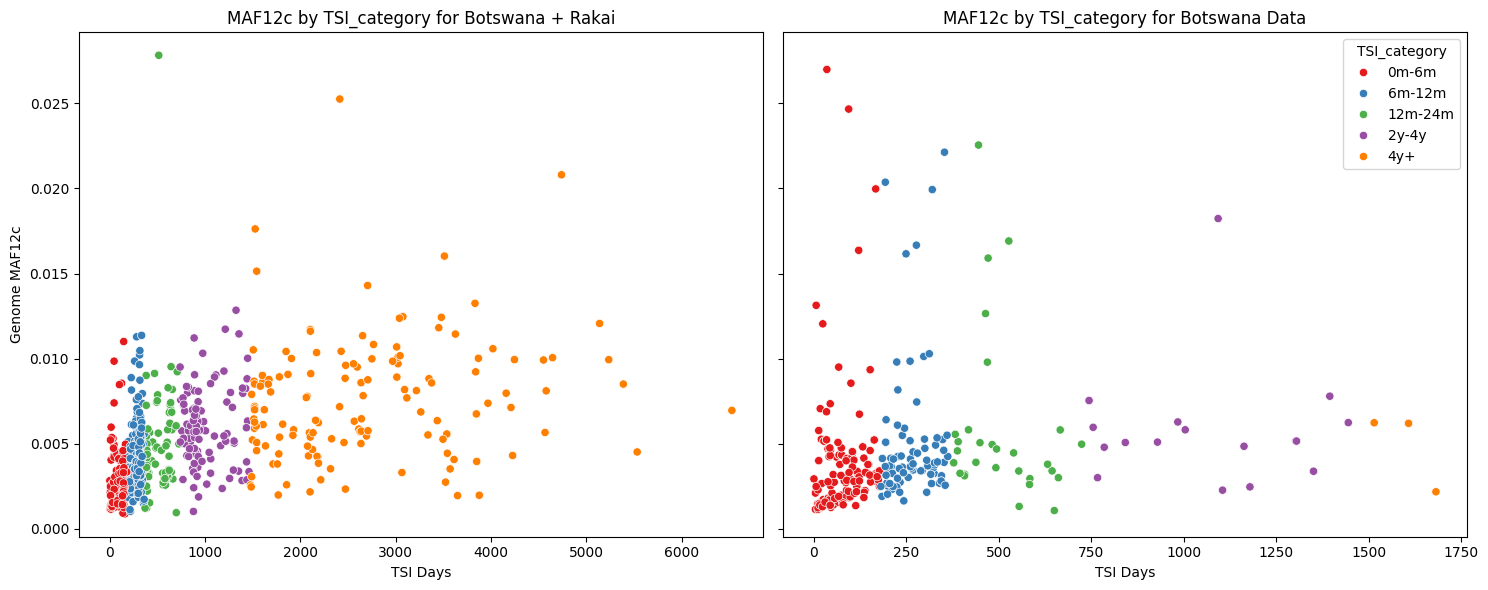

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Plot 1: mean_lrtt_features
sns.scatterplot(ax=axes[0], data=mean_features, x='TSI_days', y='genome_maf12c', hue='TSI_category', palette='Set1', legend = False)
axes[0].set_title('MAF12c by TSI_category for Botswana + Rakai')
axes[0].set_xlabel('TSI Days')
axes[0].set_ylabel('Genome MAF12c')

# Plot 2: agg_data_df
sns.scatterplot(ax=axes[1], data=agg_data_df, x='TSI_days', y='genome_maf12c', hue='TSI_category', palette='Set1')
axes[1].set_title('MAF12c by TSI_category for Botswana Data')
axes[1].set_xlabel('TSI Days')
axes[1].set_ylabel('')


plt.tight_layout()
plt.show()

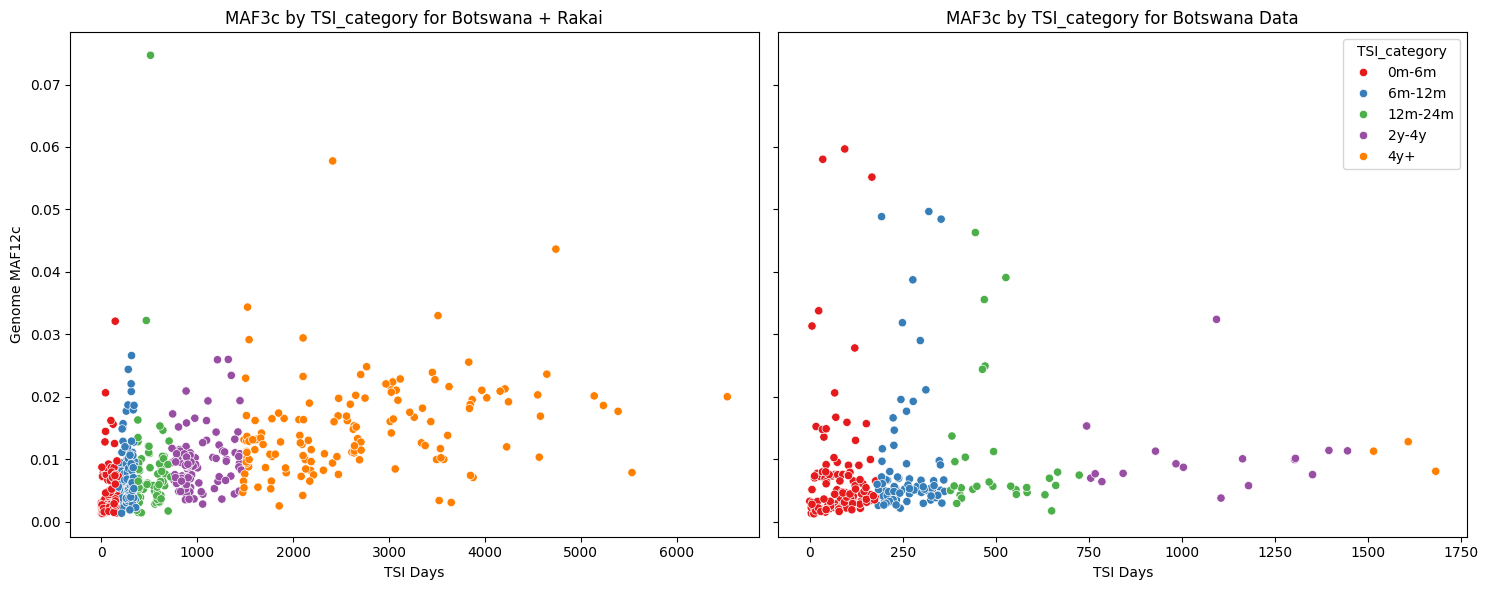

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Plot 1: mean_lrtt_features
sns.scatterplot(ax=axes[0], data=mean_features, x='TSI_days', y='genome_maf3c', hue='TSI_category', palette='Set1', legend = False)
axes[0].set_title('MAF3c by TSI_category for Botswana + Rakai')
axes[0].set_xlabel('TSI Days')
axes[0].set_ylabel('Genome MAF12c')

# Plot 2: agg_data_df
sns.scatterplot(ax=axes[1], data=agg_data_df, x='TSI_days', y='genome_maf3c', hue='TSI_category', palette='Set1')
axes[1].set_title('MAF3c by TSI_category for Botswana Data')
axes[1].set_xlabel('TSI Days')
axes[1].set_ylabel('')


plt.tight_layout()
plt.show()

# 3 - AMBIGUITY

In [36]:
ambig = pd.read_csv('./data/derived/ambiguity/fraction_ambiguous_nucleotides_combined.csv')
mean_features = pd.merge(mean_features, ambig, on=['RENAME_ID', 'TSI_days'], how='inner')

In [37]:
predictor_sets = {
    'Alex_Ambiguity (B+U)': ["gag_lrtt", "gag_tips", "gag_maf3c", "pol_lrtt", "gp120_lrtt", "gp120_tips", "gp41_tips" ,"gp41_maf12c","gp41_maf3c", "Fraction_Ambiguous"], 
    'Genome_Ambiguity (B+U)': ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_tips', 'Fraction_Ambiguous'],
    #'LRTT_Ambiguity (B+U)': ['genome_lrtt', 'gag_lrtt', 'pol_lrtt', 'gp120_lrtt', 'gp41_lrtt', 'Fraction_Ambiguous'],
    'ENV_Ambiguity (B+U)': ['gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'Fraction_Ambiguous'],
    'GAG_ENV_Ambiguity (B+U)': ['gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips','gag_lrtt','gag_maf12c', 'gag_maf3c', 'gag_tips','Fraction_Ambiguous'],
    'All_Ambiguity (B+U)': ['genome_lrtt', 'genome_maf12c', 'genome_maf3c','genome_tips' ,'gag_lrtt', 'gag_tips','gag_maf12c', 'gag_maf3c', 'pol_lrtt',
            'pol_tips','pol_maf12c', 'pol_maf3c', 'gp120_lrtt', 'gp120_tips', 'gp120_maf12c', 'gp120_maf3c', 'gp41_lrtt', 'gp41_tips', 'gp41_maf12c', 'gp41_maf3c', 'Fraction_Ambiguous'],
    'Genome_ENV_GAG_Ambiguity (B+U)': ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_tips' , 'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'Fraction_Ambiguous'], 
}

#PREDICTOR AND TARGET SET
X = mean_features.drop(columns=[target_column])
y = mean_features[target_column]
#TRAIN AND TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_split, random_state=42)

In [38]:
results = []

for set_name, predictors in predictor_sets.items():
    accuracy = run_forest_class(X_train, y_train, X_test, y_test, predictors)
    results.append({'Predictor Set': set_name, 'Accuracy': accuracy})

results_ambig = pd.DataFrame(results)
results_ambig.sort_values(by = 'Accuracy', ascending=False)

,Predictor Set,Accuracy
3,GAG_ENV_Ambiguity (B+U),0.585987
5,Genome_ENV_GAG_Ambiguity (B+U),0.566879
4,All_Ambiguity (B+U),0.547771
2,ENV_Ambiguity (B+U),0.528662
0,Alex_Ambiguity (B+U),0.522293
1,Genome_Ambiguity (B+U),0.496815


# 4 - GC Content

In [121]:
cg = pd.read_csv('./data/derived/cg_bias/hiv_cg_bias.csv')
mean_features = pd.merge(mean_features, cg, on=['RENAME_ID', 'TSI_days'], how='inner')

In [122]:
predictor_sets = {
    'Alex_GC': ["gag_lrtt", "gag_maf3c", "pol_lrtt", "gp120_lrtt" ,"gp41_maf12c","gp41_maf3c", 'window_gc_content'], 
    'Genome_GC': ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_tips', 'window_gc_content'],
    'LRTT_GC': ['genome_lrtt', 'gag_lrtt', 'pol_lrtt', 'gp120_lrtt', 'gp41_lrtt', 'window_gc_content'],
    'ENV_GC': ['gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'window_gc_content'],
    'GAG_ENV_GC': ['gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'window_gc_content'],
    'All_GC': ['genome_lrtt', 'genome_maf12c', 'genome_maf3c','genome_tips' ,'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'pol_lrtt',
            'pol_maf12c', 'pol_maf3c', 'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp41_lrtt','gp41_maf12c', 'gp41_maf3c', 'window_gc_content'],
    'Genome_ENV_GAG_GC': ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_tips' , 'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'window_gc_content'], 
}
#PREDICTOR AND TARGET SET
X = mean_features.drop(columns=[target_column])
y = mean_features[target_column]
#TRAIN AND TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split, random_state=42)

In [ ]:
results = []

for set_name, predictors in predictor_sets.items():
    accuracy = run_forest_class(X_train, y_train, X_test, y_test, predictors)
    results.append({'Predictor Set': set_name, 'Accuracy': accuracy})

results_cg = pd.DataFrame(results)
results_cg.sort_values(by = 'Accuracy', ascending=False)

# 5 - SMOOTHED VALUES

In [43]:
phylo = pd.read_csv('./data/derived/smoothed/whittaker_lrtt.csv')
maf = pd.read_csv('./data/derived/window_MAF.csv')

/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_68087/2178460546.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  phylo = pd.read_csv('./data/derived/smoothed/whittaker_lrtt.csv')


In [41]:
first_second_codon_pos, third_codon_pos, gag, pol, gp120, gp41 = load_reference_data2('./data/')

In [44]:
mean_lrtt_features = generate_lrtt_features(phylo, gag, pol, gp120, gp41, feature = 'smoothed_lrtt')
mean_lrtt_features = stratify5(mean_lrtt_features)
mean_maf_features = generate_maf_features(maf, gag, pol, gp120, gp41)

#MERGE AGGREGATED FEATURES
mean_features = pd.merge(mean_lrtt_features, mean_maf_features, on=['RENAME_ID', 'TSI_days'], how = 'inner')
mean_features = stratify5(mean_features)

In [48]:
predictor_sets = {
    'Alex_Smooth_LRTT': ["gag_lrtt", "gag_tips", "gag_maf3c", "pol_lrtt", "gp120_lrtt", "gp120_tips", "gp41_tips" ,"gp41_maf12c","gp41_maf3c"], #without tips 
    'Genome_Smooth_LRTT': ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_tips'],
    #'LRTT (B+U)': ['genome_lrtt', 'gag_lrtt', 'pol_lrtt', 'gp120_lrtt', 'gp41_lrtt'],
    'ENV_Smooth_LRTT': ['gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c'],
    'GAG_ENV_Smooth_LRTT': ['gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips', 'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips'],
    'All_Smooth_LRTT': ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_tips', 'gag_lrtt', 'gag_tips', 'gag_maf12c', 'gag_maf3c', 'pol_lrtt', 'pol_tips',
            'pol_maf12c', 'pol_maf3c', 'gp120_lrtt', 'gp120_tips', 'gp120_maf12c', 'gp120_maf3c', 'gp41_lrtt', 'gp41_tips','gp41_maf12c', 'gp41_maf3c'],
    'Genome_ENV_GAG_Smooth_LRTT': ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_tips' , 'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gag_lrtt', 'gag_maf12c', 'gag_maf3c'],  
}

#PREDICTOR AND TARGET SET
X = mean_features.drop(columns=[target_column])
y = mean_features[target_column]
#TRAIN AND TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split, random_state=42)

In [49]:
results = []

for set_name, predictors in predictor_sets.items():
    accuracy = run_forest_class(X_train, y_train, X_test, y_test, predictors)
    results.append({'Predictor Set': set_name, 'Accuracy': accuracy})

results_lrtt_smooth = pd.DataFrame(results)
results_lrtt_smooth.sort_values(by = 'Accuracy', ascending=False)

,Predictor Set,Accuracy
5,Genome_ENV_GAG_Smooth_LRTT,0.573248
3,GAG_ENV_Smooth_LRTT,0.566879
4,All_Smooth_LRTT,0.560510
0,Alex_Smooth_LRTT,0.522293
1,Genome_Smooth_LRTT,0.509554
2,ENV_Smooth_LRTT,0.433121


# 6 - TANYA SETS

In [52]:
tanya_sets = {
    'MEAN_feats_LRTT (TANYA)': ["gag_lrtt", "pol_lrtt", "gp120_lrtt" ,"gag_maf3c","gp41_maf3c", "gag_tips", "gp41_tips", "gp120_tips"], 
    'MEANS_feats (TANYA)': ['genome_lrtt', 'genome_maf3c', 'gag_lrtt', 'gag_maf3c', 'pol_lrtt', 'gp41_lrtt', 'pol_maf12c'],
    'MEANS_notips (TANYA)': ['gag_lrtt', 'gag_maf3c', 'gag_maf12c', 'pol_lrtt', 'pol_maf3c', 'pol_maf12c', 'gp120_lrtt', 'gp120_maf3c', 'gp120_maf12c', 'gp41_lrtt', 'gp41_maf3c', 'gp41_maf12c', 'genome_lrtt', 
                            'genome_maf12c', 'genome_maf3c'],
    'GPE_MEANS (TANYA)': ['genome_tips', 'gag_lrtt', 'gag_tips', 'gag_maf3c', 'gag_maf12c', 'pol_lrtt', 'pol_tips', 'pol_maf3c', 'pol_maf12c', 'gp120_lrtt', 'gp120_tips', 'gp120_maf3c', 'gp120_maf12c', 'gp41_lrtt', 'gp41_tips', 'gp41_maf3c', 'gp41_maf12c'],
    'LRTT_MEANS (TANYA)': ['gag_lrtt', 'pol_lrtt', 'gp120_lrtt', 'gp41_lrtt', 'genome_lrtt']
}

#PREDICTOR AND TARGET SET
X = mean_features.drop(columns=[target_column])
y = mean_features[target_column]
#TRAIN AND TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split, random_state=42)
results = []

for set_name, predictors in tanya_sets.items():
    accuracy = run_forest_class(X_train, y_train, X_test, y_test, predictors)
    results.append({'Predictor Set': set_name, 'Accuracy': accuracy})

results_tanya = pd.DataFrame(results)
results_tanya.sort_values(by = 'Accuracy', ascending=False)

,Predictor Set,Accuracy
2,MEANS_notips (TANYA),0.579618
3,GPE_MEANS (TANYA),0.547771
1,MEANS_feats (TANYA),0.528662
0,MEAN_feats_LRTT (TANYA),0.503185
4,LRTT_MEANS (TANYA),0.445860


# FINAL RESULTS TABLE

In [59]:
combined_df = pd.concat([results_df, results_ambig, results_tanya, results_lrtt_smooth], axis=0, ignore_index=True)

In [60]:
combined_df.sort_values(by = 'Accuracy', ascending=False)

,Predictor Set,Accuracy
0,Alex (Botswana),0.619718
4,All (Botswana),0.605634
3,GAG_ENV (Botswana),0.591549
5,Genome_ENV_GAG (Botswana),0.591549
1,Full Genome (Botswana),0.591549
15,GAG_ENV_Ambiguity (B+U),0.585987
20,MEANS_notips (TANYA),0.579618
11,Genome_ENV_GAG (B+U),0.573248
28,Genome_ENV_GAG_Smooth_LRTT,0.573248
9,GAG_ENV (B+U),0.566879


# FEATURE IMPORTANCE

Accuracy: 0.59


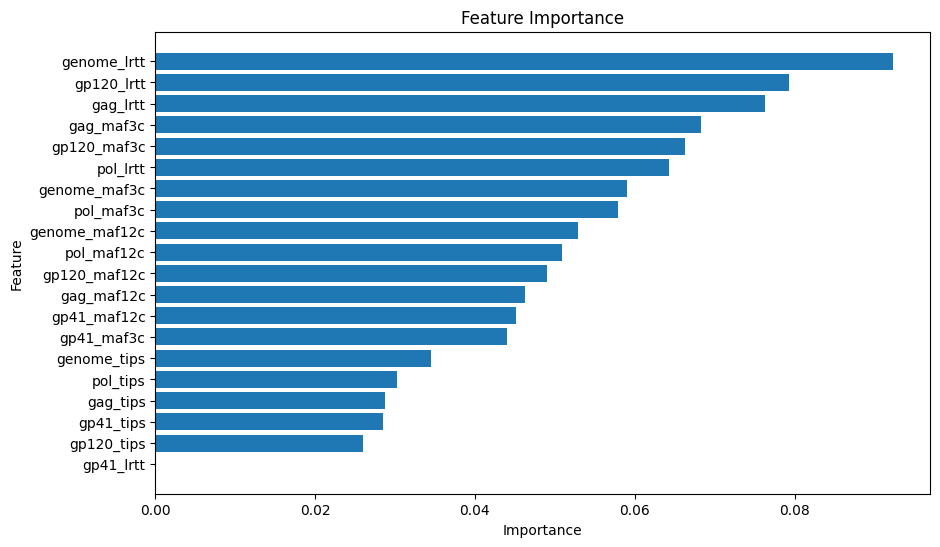

In [134]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
target_column = 'TSI_category'
selected_features = ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_tips', 
                     'gag_lrtt', 'gag_tips', 'gag_maf12c', 'gag_maf3c', 'pol_lrtt', 
                     'pol_tips', 'pol_maf12c', 'pol_maf3c', 'gp120_lrtt', 'gp120_tips', 
                     'gp120_maf12c', 'gp120_maf3c', 'gp41_lrtt', 'gp41_tips', 
                     'gp41_maf12c', 'gp41_maf3c']

# Separate features and target
X = mean_features[selected_features]
y = mean_features[target_column]

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=test_split, random_state=42)

# Fit Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Evaluate the model
accuracy = rf_classifier.score(X_test, y_test)
print(f'Accuracy: {accuracy:.2f}')

# Extract feature importances
feature_importances = rf_classifier.feature_importances_
importance_df = pd.DataFrame({'Feature': selected_features, 'Importance': feature_importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()